# Results

In [1]:
import numpy as np
from haystack.modeling.evaluation.squad_evaluation import compute_f1
import pandas as pd
from scipy import stats
# advanced spearmanr when f1 scores are all 0
from scipy.stats.mstats import spearmanr, kendalltau

from collections import defaultdict

from transformers import AutoConfig

import seaborn

from matplotlib import pyplot

import warnings
warnings.simplefilter("ignore")

In [2]:
from cycler import cycler
# pyplot.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
pyplot.rcParams['axes.prop_cycle'] = cycler(
    color=[pyplot.cm.Paired(i) for i in np.linspace(0, 1, 6)])

In [3]:
DATA_PATH = 'data/table'

In [4]:
pd.options.display.float_format = '{:,.3f}'.format

In [5]:
!ls data/table/

Peter                                  nq_open_table_results.csv
filtered_nq_open_aug.csv               nq_open_table_results_relabelled.csv
german_quad_sas.csv                    nq_open_table_results_relabelled_1.csv
german_quad_table_results.csv          squad_all_layer_results.csv
german_quad_table_results_1.csv        squad_sas_score.csv
nq_open_results.csv                    squad_table_results.csv
nq_open_sas.csv                        squad_table_results_1.csv


In [6]:
german_quad = pd.read_csv(f'{DATA_PATH}/german_quad_table_results.csv', index_col=0)
nq_open = pd.read_csv(f'{DATA_PATH}/nq_open_table_results.csv', index_col=0)
squad = pd.read_csv(f'{DATA_PATH}/squad_table_results.csv', index_col=0)

In [6]:
# german_quad = pd.read_csv(f'{DATA_PATH}/german_quad_table_results.csv', index_col=0)
# nq_open = pd.read_csv('data/errors/nq_open_corrected_and_augmented_relabelled.csv', index_col=0)
# squad = pd.read_csv(f'{DATA_PATH}/squad_table_results.csv', index_col=0)

In [7]:
METRICS_OF_INTEREST = [
    'bleu', 'rouge_L', 'meteor', 'f1', 'bi_encoder', 'bertvanilla',
    'berttrained', 'sas', 'new_bi_encoder', 'new_berttrained'
]

In [8]:
nq_open = pd.read_csv('data/table/nq_open_table_results_relabelled.csv', index_col=0)
squad = pd.read_csv('data/table/squad_table_results_1.csv', index_col=0)
german_quad = pd.read_csv('data/table/german_quad_table_results_1.csv', index_col=0)

In [9]:
# nq_open.drop_duplicates([ 'answer1', 'answer2']).to_csv('data/table/nq_open_table_results_relabelled.csv')


In [10]:
# from datasets import load_metric

# # ### Bleu 

# bleu = load_metric('bleu')

# for dataset in [nq_open]:
#     temp_1 = dataset.apply(lambda x: str(x.answer1).split(), axis=1) 
#     temp_2 = dataset.apply(lambda x: str(x.answer2).split(), axis=1)

#     bleu_scores = []
#     for i in range(len(dataset.answer1)):
#         bleu_scores.append(bleu.compute(
#             predictions=[temp_1[i]], references=[[temp_2[i]]])['bleu'])
#     dataset['bleu'] = bleu_scores

# ### Rouge

# rouge = load_metric('rouge', seed=42)

# for dataset in [nq_open]:
#     dataset['rouge_L'] = dataset.apply(lambda x: rouge.compute(
#         predictions=[str(x.answer1)], 
#         references=[str(x.answer2)], 
#         rouge_types=["rougeL"], 
#         use_agregator=False)['rougeL'][0].fmeasure,
#                                       axis = 1)

# ### Meteor

# meteor = load_metric('meteor')


# for dataset in [nq_open]:
#     dataset['meteor'] = dataset.apply(lambda x: meteor.compute(
#         predictions=[str(x.answer1)], references=[str(x.answer2)])['meteor'],
#                                       axis=1)

# # german_quad.to_csv(f'{DATA_PATH}/german_quad_table_results.csv')
# # nq_open.to_csv(f'{DATA_PATH}/nq_open_table_results.csv')
# # squad.to_csv(f'{DATA_PATH}/squad_table_results.csv')

## Table

In [9]:
def get_datasets_info():
    datasets = [squad, german_quad, nq_open]
    for dataset in datasets:
        dataset.drop_duplicates(inplace=True)
        dataset['answer_1_len'] = dataset.apply(lambda x: len(str(x.answer1)), axis=1)
        dataset['answer_2_len'] = dataset.apply(lambda x: len(str(x.answer2)), axis=1)

    dataset_f1_scores = {
        'SQuAD': [
            squad[squad.f1 == 0].shape[0],
            squad[squad.f1 != 0].shape[0]
        ],
        'GermanQuAD': [
            german_quad[german_quad.f1 == 0].shape[0],
            german_quad[german_quad.f1 != 0].shape[0]
        ],
        'NQ-open': [
            nq_open[nq_open.f1 == 0].shape[0],
            nq_open[nq_open.f1 != 0].shape[0]
        ]
    }

    dataset_table = pd.DataFrame(dataset_f1_scores).T

    dataset_table['Size'] = list(map(len, [squad, german_quad, nq_open]))

    dataset_table['Average answer size'] = [
        round(np.mean([np.mean(dataset.answer_1_len),
                 np.mean(dataset.answer_2_len)])) for dataset in datasets
    ]

    return dataset_table

In [10]:
def create_results_table(datasets, return_paper_labels=True):
    all_results = defaultdict(list)

    temp = pd.DataFrame(columns=METRICS_OF_INTEREST)
    temp_fn0 = pd.DataFrame(columns=METRICS_OF_INTEREST)


    for index, dataset in enumerate(datasets):
        for metric in temp.columns: 
            temp.loc['rho_prime', metric] = np.nan_to_num(round(
                stats.pearsonr(dataset[dataset.f1 == 0].dropna()[metric],
                         dataset[dataset.f1 == 0].dropna()['label'])[0], 3))
            temp.loc['rho', metric] = np.nan_to_num(round(
                spearmanr(dataset[dataset.f1 == 0].dropna()[metric],
                         dataset[dataset.f1 == 0].dropna()['label'])[0], 3))
            temp.loc['tau', metric] = np.nan_to_num(round(
                stats.kendalltau(dataset[dataset.f1 == 0].dropna()[metric],
                         dataset[dataset.f1 == 0].dropna()['label'])[0], 3))
            temp_fn0.loc['rho_prime', metric] = np.nan_to_num(round(
                stats.pearsonr(dataset[dataset.f1 != 0].dropna()[metric],
                         dataset[dataset.f1 != 0].dropna()['label'])[0], 3))
            temp_fn0.loc['rho', metric] = np.nan_to_num(round(
                stats.spearmanr(dataset[dataset.f1 != 0].dropna()[metric],
                         dataset[dataset.f1 != 0].dropna()['label'])[0], 3))
            temp_fn0.loc['tau', metric] = np.nan_to_num(round(
                stats.kendalltau(dataset[dataset.f1 != 0].dropna()[metric],
                         dataset[dataset.f1 != 0].dropna()['label'])[0], 3))
            dataset_results = pd.concat([temp, temp_fn0], axis=0)
        all_results[index].append(dataset_results)
    new_df = pd.DataFrame()
    for i in range(len(datasets)):
        new_df = pd.concat([new_df , all_results[i][0].T], axis=1)
    if return_paper_labels: 

        new_df.index = [
            'BLEU', 'ROUGE-L', 'METEOR', 'F1-score', 'Bi-Encoder', 'BERTScore vanilla',
            'BERTScore trained', 'SAS', 'New Bi-Encoder', 'New BERTScore trained'
        ]
    return new_df

In [11]:
def get_models_info():
    all_models = [
        'deepset/gbert-large-sts', 
        'cross-encoder/stsb-roberta-large',
        'T-Systems-onsite/cross-en-de-roberta-sentence-transformer',
        'bert-base-uncased',
        'deepset/gelectra-base',
        '/Users/faridamustafazade/Desktop/Project/cross-en-de-roberta-sentence-transformer-2021-10-30_19-42-43'
    ]

    configs = [AutoConfig.from_pretrained(i) for i in all_models]

    config_df = pd.concat([pd.DataFrame(
        AutoConfig.from_pretrained(model_type).get_config_dict(model_type)).iloc[
                0:1, :].T for model_type in all_models], axis=1)

    config_df.columns = all_models
    return config_df

In [12]:
def add_gridlines_remove_spines():
    ''' Prettify matplotlib plots by adding grid lines and removing right and top spines. '''
    axes = pyplot.gcf().get_axes()
    for axis in axes:
        axis.set_axisbelow(True)
        axis.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.6)
        axis.minorticks_on()
        axis.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    seaborn.despine()

In [15]:
old = pd.read_csv('data/table/nq_open_table_results.csv', index_col=0)

In [16]:
labels = pd.concat([
    squad.label.value_counts(normalize=True),
    german_quad.label.value_counts(normalize=True),
    nq_open.label.value_counts(normalize=True),
],
    axis=1)

In [18]:
labels.columns = get_datasets_info().T.columns


pd.concat([labels * 100, get_datasets_info().T])

,SQuAD,GermanQuAD,NQ-open
0.0,56.582,27.251,71.706
1.0,30.679,51.422,16.634
2.0,12.739,21.327,11.661
0,565.000,124.000,"3,030.000"
1,374.000,299.000,529.000
Size,939.000,423.000,"3,559.000"
Average answer size,23.000,68.000,13.000


In [19]:
get_models_info()

,deepset/gbert-large-sts,cross-encoder/stsb-roberta-large,T-Systems-onsite/cross-en-de-roberta-sentence-transformer,bert-base-uncased,deepset/gelectra-base,/Users/faridamustafazade/Desktop/Project/cross-en-de-roberta-sentence-transformer-2021-10-30_19-42-43
_name_or_path,deepset/gbert-large,NaN,NaN,NaN,NaN,/root/.cache/torch/sentence_transformers/T-Systems-onsite_cross-en-de-robert...
architectures,[BertForSequenceClassification],[RobertaForSequenceClassification],[XLMRobertaModel],[BertForMaskedLM],[ElectraForPreTraining],[XLMRobertaModel]
attention_probs_dropout_prob,0.100,0.100,0.100,0.100,0.100,0.100
gradient_checkpointing,False,False,False,False,NaN,False
hidden_act,gelu,gelu,gelu,gelu,gelu,gelu
hidden_dropout_prob,0.100,0.100,0.100,0.100,NaN,0.100
hidden_size,"1,024.000","1,024.000",768.000,768.000,768.000,768.000
id2label,{'0': 'LABEL_0'},{'0': 'LABEL_0'},NaN,NaN,NaN,NaN
initializer_range,0.020,0.020,0.020,0.020,0.020,0.020
intermediate_size,"4,096.000","4,096.000","3,072.000","3,072.000","3,072.000","3,072.000"


In [56]:
# old_results = create_results_table([nq_open])

In [20]:
new_results = create_results_table([squad, nq_open])

In [21]:
new_results

,rho_prime,rho,tau,rho_prime,rho,tau,rho_prime,rho,tau,rho_prime,rho,tau
BLEU,0.000,0.000,0.000,0.183,0.169,0.161,0.000,0.000,0.000,0.052,0.054,0.051
ROUGE-L,0.100,0.043,0.041,0.553,0.534,0.452,0.220,0.163,0.159,0.452,0.460,0.379
METEOR,0.398,0.207,0.200,0.446,0.460,0.375,0.226,0.149,0.145,0.189,0.181,0.141
F1-score,0.000,0.000,0.000,0.591,0.576,0.494,0.000,0.000,0.000,0.396,0.408,0.338
Bi-Encoder,0.487,0.372,0.303,0.684,0.684,0.565,0.290,0.210,0.169,0.456,0.448,0.353
BERTScore vanilla,0.249,0.131,0.107,0.609,0.598,0.490,0.153,0.167,0.134,0.165,0.142,0.112
BERTScore trained,0.517,0.391,0.318,0.698,0.689,0.571,0.315,0.223,0.179,0.454,0.450,0.355
SAS,0.561,0.358,0.291,0.742,0.734,0.613,0.419,0.194,0.156,0.662,0.646,0.512
New Bi-Encoder,0.501,0.391,0.318,0.694,0.690,0.573,0.335,0.251,0.202,0.503,0.503,0.393
New BERTScore trained,0.519,0.399,0.324,0.708,0.699,0.582,0.018,0.032,0.025,0.010,0.019,0.015


In [26]:
create_results_table([german_quad]).drop('METEOR').iloc[:-2, :]

,rho_prime,rho,tau,rho_prime,rho,tau
BLEU,0.000,0.000,0.000,0.153,0.095,0.089
ROUGE-L,0.172,0.106,0.100,0.579,0.554,0.460
F1-score,0.000,0.000,0.000,0.560,0.534,0.443
Bi-Encoder,0.392,0.337,0.273,0.596,0.595,0.491
BERTScore vanilla,0.149,0.008,0.006,0.599,0.554,0.457
BERTScore trained,0.410,0.349,0.284,0.606,0.592,0.489
SAS,0.488,0.432,0.349,0.713,0.690,0.574


In [27]:
# ((new_results.iloc[:-2, 6:] - old_results) / new_results.iloc[:-2, 6:] *
#  100).dropna()

In [62]:
def vis_hist_label(df_):
    print()
    print(df_["label"].unique(), df_["label"].count())
#     sns.set(style="darkgrid")
    fig, axs = pyplot.subplots(2, 2, figsize=(7, 7))
    df_["f1_0"] = df_["f1"]==0
    seaborn.histplot(data=df_, x="bi_encoder", kde=True, ax=axs[0, 0], binrange=[0,1], hue="f1_0")
    seaborn.histplot(data=df_, x="bertvanilla", kde=True, ax=axs[0, 1], binrange=[0,1], hue="f1_0")
    seaborn.histplot(data=df_, x="berttrained", kde=True,  ax=axs[1, 0], binrange=[0,1], hue="f1_0")
    seaborn.histplot(data=df_, x="sas", kde=True, ax=axs[1, 1], binrange=[0,1], hue="f1_0")
    fig.suptitle('GermanQuAD (F1=0 vs. F1!=0)')
    pyplot.savefig('data/images/corrs_german_quad_peter.pdf', bbox_inches='tight')

    add_gridlines_remove_spines()
#     plt.show()


[ 0.  1.  2. nan] 422


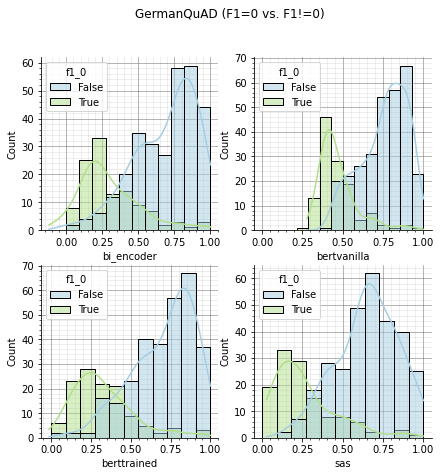

In [63]:
vis_hist_label(german_quad);

## Score analysis

In [31]:
combo

,answer1,answer2,label,bleu,rouge_L,meteor,f1,bi_encoder,bertvanilla,berttrained,sas,new_bi_encoder,new_berttrained,dataset_type
0,Seine,Epte,0.000,0.000,0.000,0.000,0.000,0.423,0.249,0.378,0.010,0.197,0.240,SQuAD
1,Norman mercenary,an Italo-Norman named Raoul,1.000,0.000,0.286,0.000,0.000,0.440,0.461,0.426,0.350,0.326,0.325,SQuAD
2,1018,1064,0.000,0.000,0.000,0.000,0.000,0.472,0.716,0.430,0.193,0.372,0.351,SQuAD
3,Isaac Komnenos,Isaac,1.000,0.000,0.667,0.455,0.667,0.564,0.505,0.609,0.747,0.475,0.537,SQuAD
4,dukes,the dukes,2.000,0.000,0.667,0.263,1.000,0.967,0.844,0.959,0.898,0.982,0.976,SQuAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3554,Rome,gaul,1.000,0.000,0.000,0.000,0.000,0.065,0.373,0.029,0.011,-0.045,0.515,NQ-open
3555,Robert de La Salle,la salle,1.000,0.000,0.667,0.852,0.667,0.245,0.759,0.230,0.738,0.465,0.404,NQ-open
3556,Robert de La Salle,John Law,0.000,0.000,0.000,0.000,0.000,0.283,0.297,0.265,0.010,0.185,0.139,NQ-open
3557,Robert de La Salle,René-Robert Cavelier,0.000,0.000,0.286,0.000,0.000,0.228,0.424,0.270,0.087,0.141,0.087,NQ-open


In [32]:
temp = squad.copy()

temp['dataset_type'] = 'SQuAD'

temp2 = german_quad.copy()
temp2['dataset_type'] = 'GermanQUAD'

temp3 = nq_open.copy()
temp3['dataset_type'] = 'NQ-open'

combo = pd.concat([temp, temp2[temp.columns], temp3[temp.columns]])

# new_df = pd.DataFrame()
# for i in range(3):
#     new_df = pd.concat([new_df , all_results[i][0].T], axis=1)
new_df = create_results_table([squad, german_quad, nq_open],
                              return_paper_labels=False)


new_df.loc['meteor'] = list(new_df.loc['meteor'].values[:4]) +  \
    [np.nan, np.nan, np.nan, np.nan] + list(new_df.loc['meteor'].values[8:])
combo = combo[['answer1', 'answer2', 'label'] + list(new_df.index) +
              ['dataset_type']]

combo.columns = [
    'answer1', 'answer2', 'Human', 'BLEU', 'ROUGE-L', 'METEOR', 'F1-score',
    'Bi-Encoder', 'BERTScore vanilla', 'BERTScore trained', 'SAS',
    'New Bi-Encoder', 'New BETRScore trained', 'dataset_type'
]

In [33]:
df = pd.melt(combo,
             value_vars=[
                 'BLEU',
                 'ROUGE-L',
                 'METEOR',
                 'F1-score',
                 'Bi-Encoder',
                 'BERTScore vanilla',
                 'BERTScore trained',
                 'SAS',
                 'New Bi-Encoder',
                 'New BETRScore trained',
             ],
             id_vars='dataset_type')

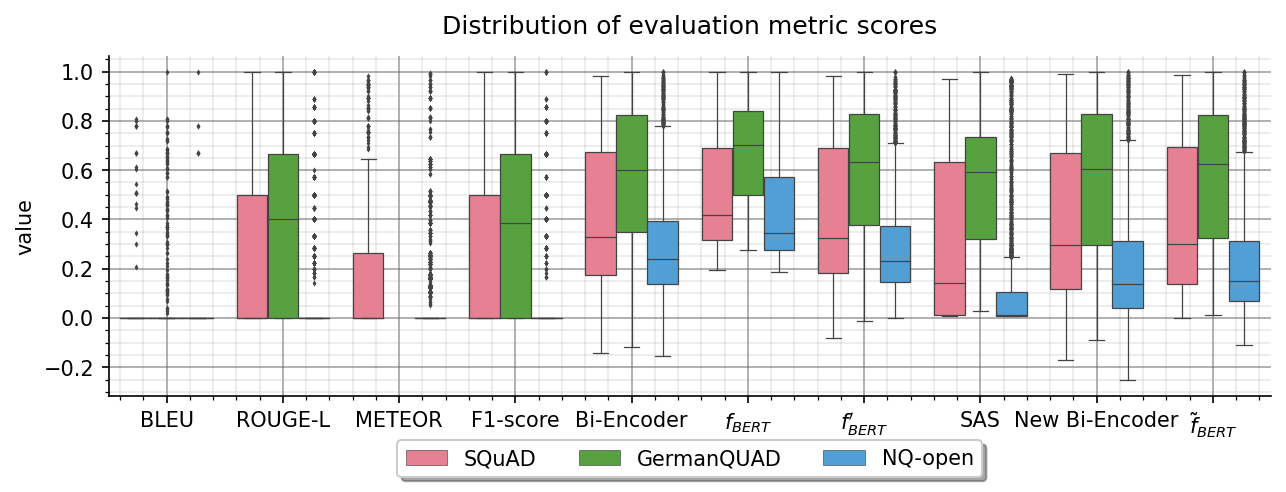

In [49]:
fig = pyplot.figure(figsize=(10, 3), dpi=150)
g = seaborn.boxplot(
    x='variable',
    y = 'value', 
    hue = 'dataset_type', 
    data=df.drop(df[(df['dataset_type'] == 'GermanQUAD') & (df.variable == 'METEOR')].index),
    palette='husl', 
    linewidth=0.6, 
    fliersize=.75)
pyplot.title('Distribution of evaluation metric scores', y=1.03)
xtick_labels = g.get_xticklabels()
g.set_xticklabels(xtick_labels[:5] + 
                  [r'$f_{BERT}$', r'$ f^{\prime}_{BERT}$'] + 
                  xtick_labels[7:9] + [r'$\tilde{f}_{BERT}$'])
# Put a legend below current axis
pyplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
# pyplot.xticks(rotation=45)
pyplot.savefig('data/images/distribution_of_scores.pdf', bbox_inches='tight')
add_gridlines_remove_spines()

## Experiment with the layers

In [13]:
import pandas as pd

from bert_score import score
from haystack.modeling.evaluation.squad_evaluation import compute_f1
from haystack.modeling.utils import initialize_device_settings
from sentence_transformers import CrossEncoder, SentenceTransformer, util
from transformers import logging

BERTTRAINED = 'bert_score_prime'
BERT_VANILLA = 'bert_score'
BERT_UNCASED = 'bert-base-uncased'
BERT_TRAINED_NEW = 'new_berttrained'
model_type_trained_1 = 'cross-en-de-roberta-sentence-transformer-2021-10-30_19-42-43'
SAS = 'sas'
F1_SCORE = 'f1'
model_type_trained = 'T-Systems-onsite/cross-en-de-roberta-sentence-transformer'

logging.set_verbosity_error()


In [142]:

# # BERTScore vanilla approach

# ## SQUAD 
# for layer in range(13):
#     _, _, bertscore = score(
#         list(squad.answer1.values),
#         list(squad.answer2.values),
#         model_type=BERT_UNCASED,
#         num_layers=layer)
#     squad[f'{layer}_{BERT_VANILLA}'] = bertscore.cpu().numpy()



# BERTScore Trained


## SQUAD 
for layer in range(13):
    _, _, bertscore = score(
        list(squad.answer1.values),
        list(squad.answer2.values),
        model_type=model_type_trained,
        num_layers=layer)
    squad[f'{layer}_{BERT_TRAINED_NEW}'] = bertscore.cpu().numpy()



In [27]:
def plot_layer_extraction(data, title: str):
    labels = []
    figure = pyplot.figure(figsize=(7, 5), dpi=100)
    corr_df = defaultdict(list)
    for corr_func, marker in zip(
            [stats.pearsonr, stats.spearmanr, stats.kendalltau], ('s', '.', 'v')):
        for bert_score_type, label in zip(
                [BERT_VANILLA, BERTTRAINED], [r'$f_{BERT}$', r'$f^{\prime}_{BERT}$']):
            corrs = []

            for layer in range(13):
                corrs.append(
                    corr_func(data.loc[:, f'{layer}_{bert_score_type}'],
                              data.label)[0])
            figure = pyplot.plot(corrs, marker=marker)
            #         pyplot.ylim(0.18, 0.51)
        
            pyplot.title(title, y=1.03)
            add_gridlines_remove_spines()
            labels.append(label + ', ' + corr_func.__name__.capitalize())
        pyplot.plot([corr_func(data.sas, data.label)[0]] * 13, ls='dashed', marker=marker)


        labels.append('SAS' + ', ' + corr_func.__name__.capitalize())

    pyplot.legend(labels,
                  loc='upper center',
                  bbox_to_anchor=(0.5, -.075),
                  fancybox=True,
                  shadow=True,
                  ncol=3)
    return figure

In [15]:
squad = pd.read_csv('data/table/squad_all_layer_results.csv')

In [189]:
# squad.to_csv('data/table/squad_all_layer_results.csv')

In [19]:
data = squad.copy()

In [21]:
data

,Unnamed: 0,answer1,answer2,label,sas,f1,berttrained,bertvanilla,bi_encoder,bleu,...,4_bert_score,5_bert_score,6_bert_score,7_bert_score,8_bert_score,9_bert_score,10_bert_score,11_bert_score,12_bert_score_prime,12_bert_score
0,0,Seine,Epte,0.000,0.010,0.000,0.378,0.249,0.423,0.000,...,0.323,0.341,0.402,0.403,0.424,0.466,0.501,0.533,0.378,0.537
1,1,Norman mercenary,an Italo-Norman named Raoul,1.000,0.350,0.000,0.426,0.461,0.440,0.000,...,0.457,0.459,0.446,0.450,0.479,0.501,0.565,0.614,0.426,0.525
2,2,1018,1064,0.000,0.193,0.000,0.430,0.716,0.472,0.000,...,0.758,0.793,0.813,0.826,0.826,0.827,0.818,0.788,0.430,0.743
3,3,Isaac Komnenos,Isaac,1.000,0.747,0.667,0.609,0.505,0.564,0.000,...,0.451,0.430,0.386,0.337,0.321,0.321,0.313,0.354,0.609,0.275
4,4,dukes,the dukes,2.000,0.898,1.000,0.959,0.844,0.967,0.000,...,0.792,0.765,0.754,0.746,0.760,0.758,0.766,0.806,0.959,0.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,937,port,additional port,1.000,0.695,0.667,0.688,0.739,0.642,0.000,...,0.709,0.680,0.668,0.642,0.669,0.684,0.643,0.689,0.688,0.595
938,938,565,565 °C,1.000,0.689,0.667,0.912,0.781,0.917,0.000,...,0.744,0.729,0.730,0.705,0.690,0.687,0.699,0.728,0.912,0.688
939,939,Stockton and Darlington,Stockton and Darlington Railway,1.000,0.576,0.857,0.929,0.829,0.943,0.000,...,0.798,0.774,0.752,0.753,0.728,0.697,0.702,0.701,0.929,0.697
940,940,cylinder volume,cylinder,1.000,0.815,0.667,0.864,0.781,0.846,0.000,...,0.745,0.748,0.731,0.699,0.683,0.658,0.672,0.706,0.864,0.637


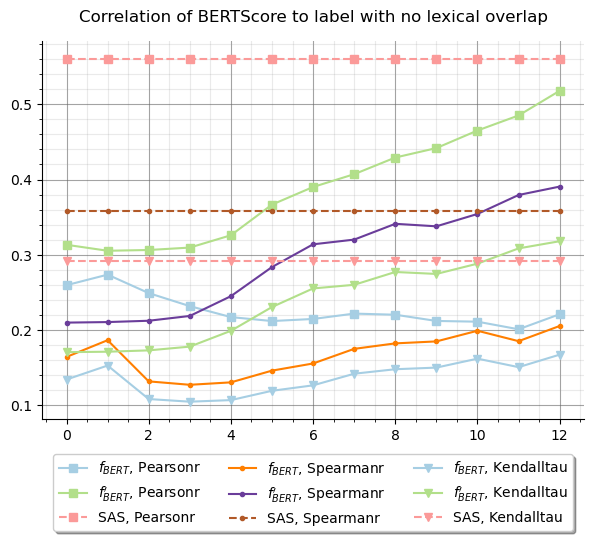

In [30]:
plot_layer_extraction(squad[squad.f1 == 0],
           'Correlation of BERTScore to label with no lexical overlap')

pyplot.savefig('data/images/corrs_f1_zero.pdf', bbox_inches='tight')

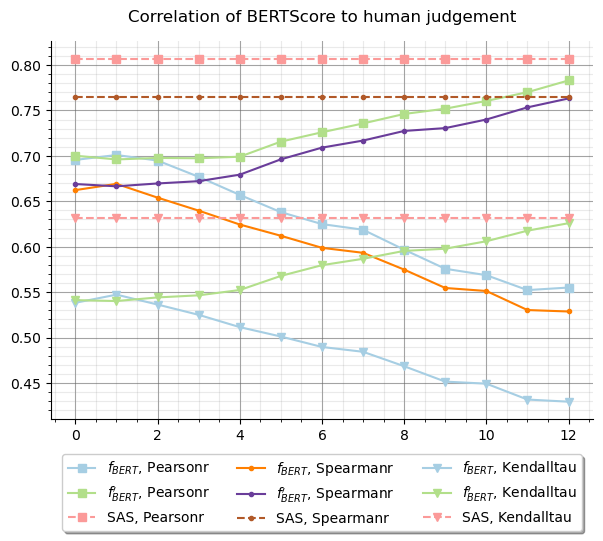

In [29]:
plot_layer_extraction(squad, 'Correlation of BERTScore to human judgement')
pyplot.savefig('data/images/corrs.pdf', bbox_inches='tight')

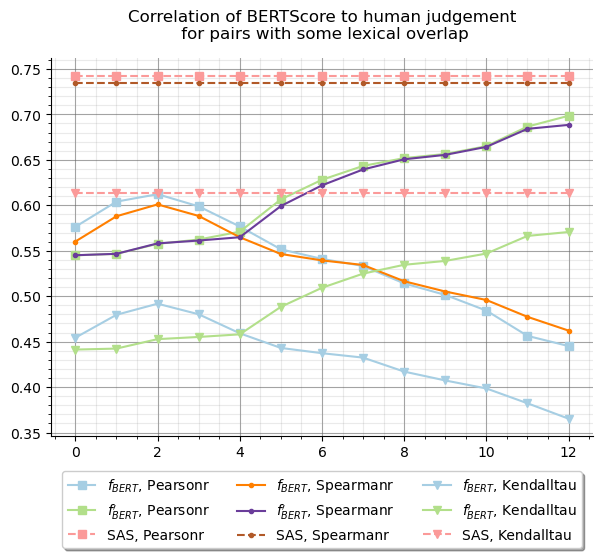

In [31]:
plot_layer_extraction(
    squad[squad.f1 != 0],
    'Correlation of BERTScore to human judgement\n for pairs with some lexical overlap'
)
pyplot.savefig('data/images/corrs_f1_non_zero.pdf', bbox_inches='tight')

## SQuAD err 

In [61]:
# pd.concat([squad[(squad.sas > 0.5 ) & (squad.label == 0)], squad[(squad.sas < 0.25 ) & (squad.label == 2)]]).to_csv('data/errors/squad_low_scores.csv')